In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

data = pd.read_csv("pwdata.csv")
data

,Date,temp,humidity,windspeed,solarradiation,description,DEMAND
0,01-01-2023,24.2,88.2,11.2,195.7,Partly cloudy throughout the day.,20.70
1,02-01-2023,23.4,89.7,18.4,146.6,Partly cloudy throughout the day with afternoo...,21.30
2,03-01-2023,22.3,82.6,16.6,195.6,Partly cloudy throughout the day.,20.44
3,04-01-2023,21.3,76.2,11.2,212.3,Clear conditions throughout the day.,20.81
4,05-01-2023,20.6,74.9,14.8,211.5,Clear conditions throughout the day.,20.81
...,...,...,...,...,...,...,...
360,27-12-2023,22.3,72.0,11.2,209.6,Clear conditions throughout the day.,23.45
361,28-12-2023,22.0,74.4,7.6,208.7,Partly cloudy throughout the day.,23.06
362,29-12-2023,21.4,74.7,14.8,199.2,Partly cloudy throughout the day.,23.11
363,30-12-2023,21.1,71.9,14.8,211.8,Clear conditions throughout the day.,23.42


In [2]:
data = data[['Date', 'DEMAND','temp','humidity']]
data

,Date,DEMAND,temp,humidity
0,01-01-2023,20.70,24.2,88.2
1,02-01-2023,21.30,23.4,89.7
2,03-01-2023,20.44,22.3,82.6
3,04-01-2023,20.81,21.3,76.2
4,05-01-2023,20.81,20.6,74.9
...,...,...,...,...
360,27-12-2023,23.45,22.3,72.0
361,28-12-2023,23.06,22.0,74.4
362,29-12-2023,23.11,21.4,74.7
363,30-12-2023,23.42,21.1,71.9


In [3]:
data['Date'] = pd.to_datetime(data['Date'],format='%d-%m-%Y')
data.set_index('Date', inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_3752\121324292.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data['Date'],format='%d-%m-%Y')


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [5]:
from copy import deepcopy as dc

def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    for i in range(1, n_steps+1):
        df[f'DEMAND(t-{i})'] = df['DEMAND'].shift(i)
        df[f'Temp(t-{i})'] = df['temp'].shift(i)
        df[f'Humidity(t-{i})'] = df['humidity'].shift(i)
       
    df.dropna(inplace=True)
    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,DEMAND,temp,humidity,DEMAND(t-1),Temp(t-1),Humidity(t-1),DEMAND(t-2),Temp(t-2),Humidity(t-2),DEMAND(t-3),...,Humidity(t-4),DEMAND(t-5),Temp(t-5),Humidity(t-5),DEMAND(t-6),Temp(t-6),Humidity(t-6),DEMAND(t-7),Temp(t-7),Humidity(t-7)
Date,,,,,,,,,,,,,,,,,,,,,
2023-01-08,19.81,19.0,58.3,20.36,18.6,57.1,20.58,20.2,68.4,20.81,...,76.2,20.44,22.3,82.6,21.30,23.4,89.7,20.70,24.2,88.2
2023-01-09,20.31,19.4,69.3,19.81,19.0,58.3,20.36,18.6,57.1,20.58,...,74.9,20.81,21.3,76.2,20.44,22.3,82.6,21.30,23.4,89.7
2023-01-10,20.98,20.5,71.5,20.31,19.4,69.3,19.81,19.0,58.3,20.36,...,68.4,20.81,20.6,74.9,20.81,21.3,76.2,20.44,22.3,82.6
2023-01-11,20.59,20.5,76.0,20.98,20.5,71.5,20.31,19.4,69.3,19.81,...,57.1,20.58,20.2,68.4,20.81,20.6,74.9,20.81,21.3,76.2
2023-01-12,20.66,21.6,88.4,20.59,20.5,76.0,20.98,20.5,71.5,20.31,...,58.3,20.36,18.6,57.1,20.58,20.2,68.4,20.81,20.6,74.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-27,23.45,22.3,72.0,22.91,22.3,71.0,22.21,21.7,66.3,22.40,...,72.8,22.62,19.3,69.9,22.76,18.6,67.4,22.98,18.3,67.0
2023-12-28,23.06,22.0,74.4,23.45,22.3,72.0,22.91,22.3,71.0,22.21,...,73.0,23.17,20.3,72.8,22.62,19.3,69.9,22.76,18.6,67.4
2023-12-29,23.11,21.4,74.7,23.06,22.0,74.4,23.45,22.3,72.0,22.91,...,66.3,22.40,21.1,73.0,23.17,20.3,72.8,22.62,19.3,69.9


In [6]:
shifted_df_as_np = shifted_df.to_numpy()
shifted_df_as_np.shape

(322, 24)

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

In [8]:
X = shifted_df_as_np[:, 3:]
y = shifted_df_as_np[:, 0]

X.shape, y.shape

((322, 21), (322,))

In [9]:
X = dc(np.flip(X, axis=1))

In [10]:
split_index = int(len(X) * 0.9)
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape


((289, 21), (33, 21), (289,), (33,))

In [11]:
num_features = X_train.shape[1] // lookback
print(f"Number of features: {num_features}")

Number of features: 3


In [12]:
assert num_features * lookback == X_train.shape[1]

In [13]:

X_train = X_train.reshape((-1, lookback, num_features))  # Adjust for dynamic features
X_test = X_test.reshape((-1, lookback, num_features))
y_train = y_train.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((289, 7, 3), (33, 7, 3), (289, 1), (33, 1))

In [14]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([289, 7, 3]),
 torch.Size([33, 7, 3]),
 torch.Size([289, 1]),
 torch.Size([33, 1]))

In [15]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]
    
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [16]:
train_dataset

In [17]:
from torch.utils.data import DataLoader

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([8, 7, 3]) torch.Size([8, 1])


In [19]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers, dropout_prob=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True, dropout=dropout_prob if num_stacked_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_size=3, hidden_size=4, num_stacked_layers=2, dropout_prob=0.2)
model.to(device)
model

LSTM(
  (lstm): LSTM(3, 4, num_layers=2, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [20]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 1 == 1:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [21]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [22]:
X_train = X_train.to(torch.float32)
X_test = X_test.to(torch.float32)
y_train = y_train.to(torch.float32)
y_test = y_test.to(torch.float32)

In [23]:
print(f"X_train shape: {X_train.shape}")  # Should be (num_samples, lookback, num_features)
print(f"y_train shape: {y_train.shape}")  # Should be (num_samples, 1)
print(f"X_test shape: {X_test.shape}")    # Should be (num_samples, lookback, num_features)
print(f"y_test shape: {y_test.shape}")    # Should be (num_samples, 1)")

X_train shape: torch.Size([289, 7, 3])
y_train shape: torch.Size([289, 1])
X_test shape: torch.Size([33, 7, 3])
y_test shape: torch.Size([33, 1])


In [63]:
learning_rate = 0.001
num_epochs = 1
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()
    

Epoch: 1

Val Loss: 0.008
***************************************************



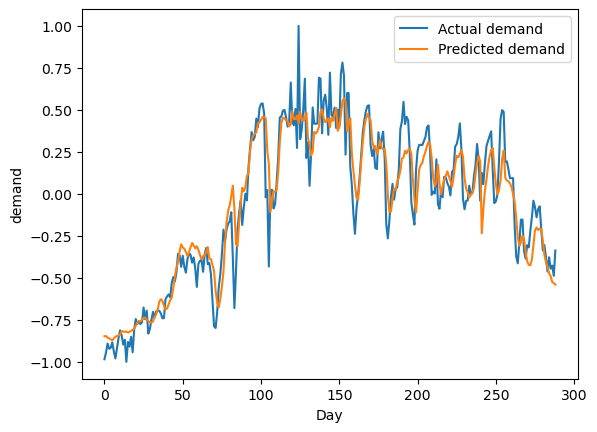

In [64]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual demand')
plt.plot(predicted, label='Predicted demand')
plt.xlabel('Day')
plt.ylabel('demand')
plt.legend()
plt.show()

In [65]:
import numpy as np
from copy import deepcopy as dc
import matplotlib.pyplot as plt

In [66]:
train_predictions = predicted.flatten()

In [67]:
if train_predictions.shape[0] != X_train.shape[0]:
    raise ValueError(f"Mismatch in the number of samples between train_predictions ({train_predictions.shape[0]}) and X_train ({X_train.shape[0]})")

num_features = X_train.shape[2] 
train_predictions.shape


(289,)

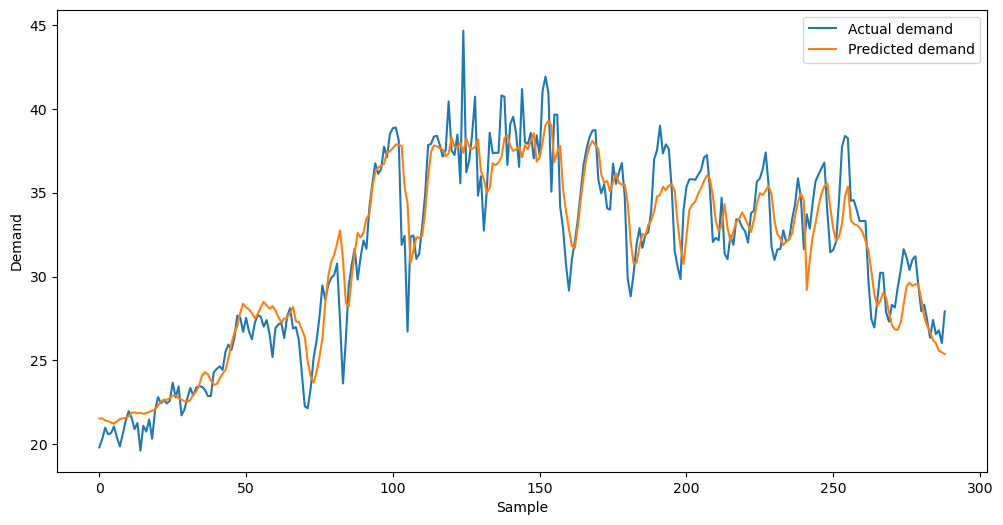

In [68]:
original_num_columns = shifted_df_as_np.shape[1]
dummies = np.zeros((X_train.shape[0], original_num_columns))

# Place train_predictions into the first column
dummies[:, 0] = train_predictions

# Inverse transform using the scaler
dummies = scaler.inverse_transform(dummies)
train_predictions = dc(dummies[:, 0])

# Perform the same steps for actual y_train values
dummies = np.zeros((X_train.shape[0], original_num_columns))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(new_y_train, label='Actual demand')
plt.plot(train_predictions, label='Predicted demand')
plt.xlabel('Sample')
plt.ylabel('Demand')
plt.legend()
plt.show()

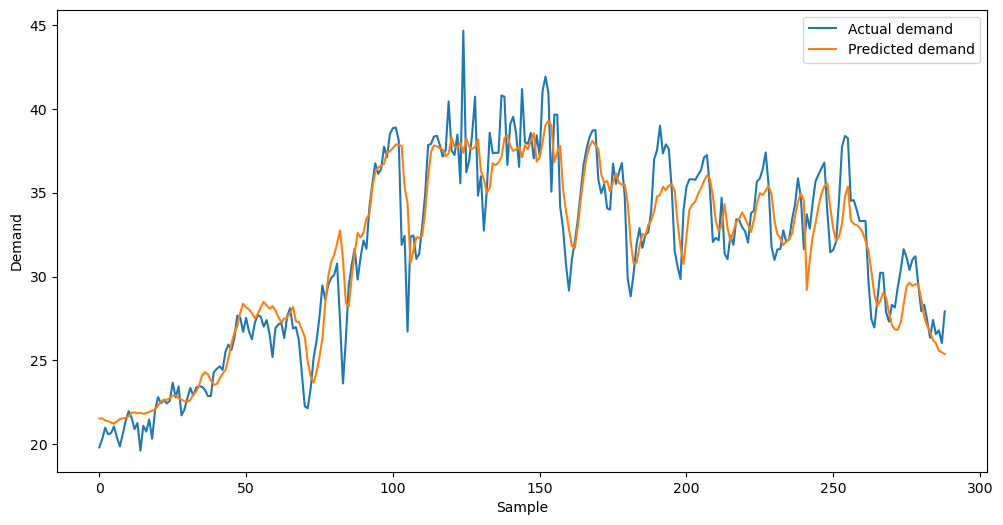

In [69]:
train_predictions = predicted.flatten()

# Check if the shape matches the expected number of samples
if train_predictions.shape[0] != X_train.shape[0]:
    raise ValueError(f"Mismatch in the number of samples between train_predictions ({train_predictions.shape[0]}) and X_train ({X_train.shape[0]})")

# Determine the number of features from X_train
num_features = X_train.shape[2]  # Since X_train is shaped (num_samples, lookback, num_features)

# Create a dummies array with the correct shape: (num_samples, num_features * lookback + 1)
original_num_columns = shifted_df_as_np.shape[1]
dummies = np.zeros((X_train.shape[0], original_num_columns))

# Place train_predictions into the first column
dummies[:, 0] = train_predictions

# Inverse transform using the scaler
dummies = scaler.inverse_transform(dummies)

# Extract the actual predictions
train_predictions = dc(dummies[:, 0])

# Perform the same steps for actual y_train values
dummies = np.zeros((X_train.shape[0], original_num_columns))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(new_y_train, label='Actual demand')
plt.plot(train_predictions, label='Predicted demand')
plt.xlabel('Sample')
plt.ylabel('Demand')
plt.legend()
plt.show()

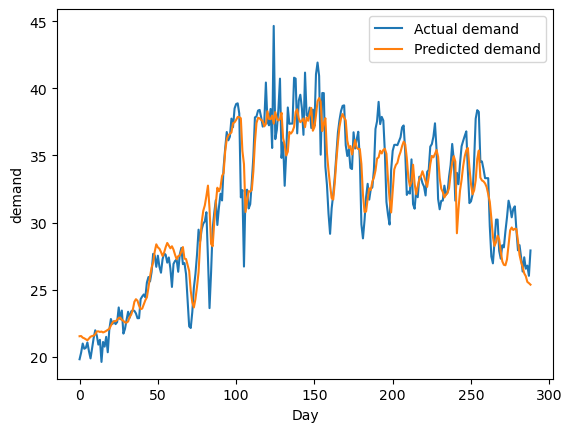

In [70]:
plt.plot(new_y_train, label='Actual demand')
plt.plot(train_predictions, label='Predicted demand')
plt.xlabel('Day')
plt.ylabel('demand')
plt.legend()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_3752\1928162163.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_predictions = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy().flatten()


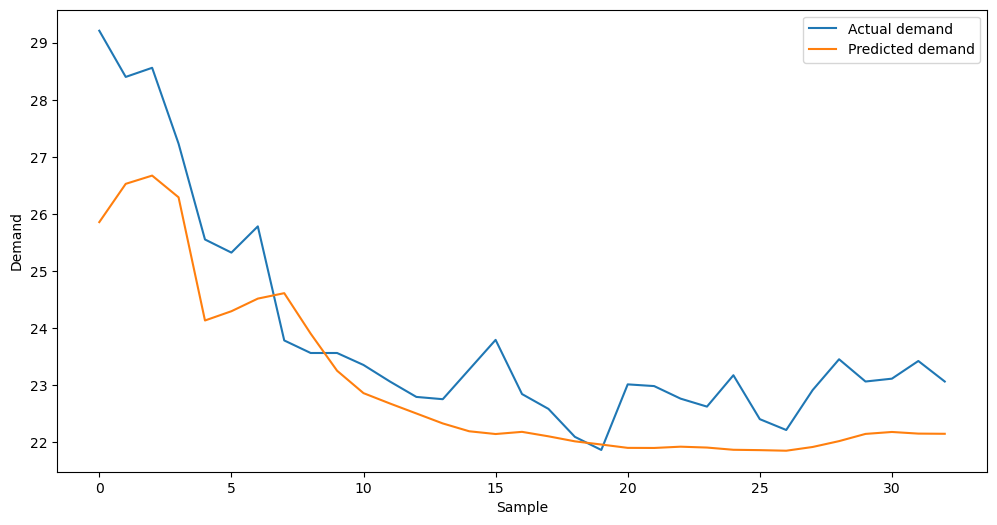

In [71]:
import numpy as np
from copy import deepcopy as dc
import matplotlib.pyplot as plt

# Generate predictions for test set
with torch.no_grad():
    model.eval()
    test_predictions = model(torch.tensor(X_test, dtype=torch.float32).to(device)).cpu().numpy().flatten()

# Check if the shape matches the expected number of samples
if test_predictions.shape[0] != X_test.shape[0]:
    raise ValueError(f"Mismatch in the number of samples between test_predictions ({test_predictions.shape[0]}) and X_test ({X_test.shape[0]})")

# Determine the number of features from X_test
num_features = X_test.shape[2]  # Since X_test is shaped (num_samples, lookback, num_features)

# Create a dummy array with the correct shape: (num_samples, original number of columns in shifted_df_as_np)
# Original number of columns = num_features * lookback + 1 (including the target column)
original_num_columns = shifted_df_as_np.shape[1]
dummies = np.zeros((X_test.shape[0], original_num_columns))

# Place test_predictions into the first column
dummies[:, 0] = test_predictions

# Inverse transform using the scaler
dummies = scaler.inverse_transform(dummies)

# Extract the actual predictions
test_predictions = dc(dummies[:, 0])

# Perform the same steps for actual y_test values
dummies = np.zeros((X_test.shape[0], original_num_columns))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(new_y_test, label='Actual demand')
plt.plot(test_predictions, label='Predicted demand')
plt.xlabel('Sample')
plt.ylabel('Demand')
plt.legend()
plt.show()


In [78]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(new_y_test,test_predictions))
print(f'RMSE: {rmse:.4f}')


# Calculate MAPE
mape = np.mean(np.abs(( new_y_test- test_predictions) /new_y_test )) * 100
print(f'MAPE: {mape:.2f}%')

RMSE: 1.1422
MAPE: 3.86%


# 

In [73]:
shifted_future_df=shifted_df_as_np[:,1:];

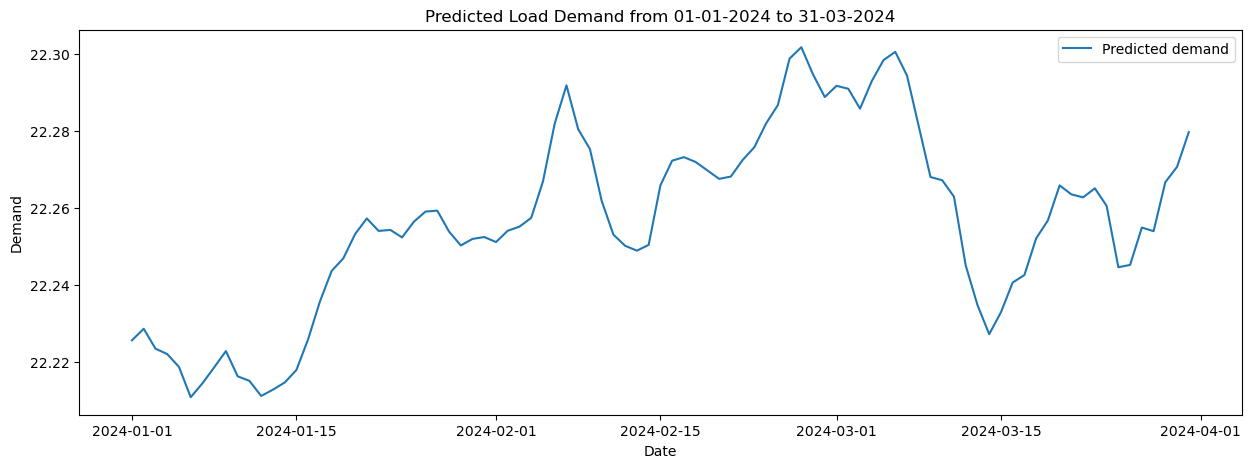

In [74]:
future_data = pd.read_excel('pwdata1.xlsx')
future_data['Date'] = pd.to_datetime(future_data['Date'], format='%d-%m-%Y')
future_data.set_index('Date', inplace=True)

# Prepare the future dataframe
def prepare_future_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    for i in range(1, n_steps+1):
        df[f'DEMAND(t-{i})'] = 0  # Placeholder to match the number of columns
        df[f'Temp(t-{i})'] = df['temp'].shift(i)
        df[f'Humidity(t-{i})'] = df['humidity'].shift(i)
    return df

# Apply the function to the future data
shifted_future_df = prepare_future_dataframe_for_lstm(future_data, lookback)
shifted_future_df=shifted_df_as_np[:, :];
#shifted_future_df_as_np = shifted_future_df.to_numpy()

# Normalize future data
shifted_future_df_as_np = scaler.transform(shifted_future_df)
X_future = shifted_future_df_as_np[:, 3:]  # Ensure the correct number of features (excluding the target)
X_future = dc(np.flip(X_future, axis=1))

# Reshape for LSTM input
X_future = X_future.reshape((-1, lookback, num_features))

# Convert to tensor
X_future = torch.tensor(X_future).float().to(device)

model.eval()
with torch.no_grad():
    future_predictions = model(X_future).cpu().numpy().flatten()

# Inverse transform predictions
dummies = np.zeros((X_future.shape[0], shifted_df_as_np.shape[1]))
dummies[:, 0] = future_predictions
dummies = scaler.inverse_transform(dummies)
future_predictions = dc(dummies[:, 0])

# Create DataFrame for future predictions
future_dates = pd.date_range(start='2024-01-01', periods=len(future_predictions), freq='D')
future_predictions_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['DEMAND'])
future_predictions_df = future_predictions_df[(future_predictions_df.index >= '2024-01-01') & (future_predictions_df.index <= '2024-03-31')]
# Plot future predictions
plt.figure(figsize=(15, 5))
plt.plot(future_predictions_df, label='Predicted demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Predicted Load Demand from 01-01-2024 to 31-03-2024')
plt.legend()
plt.show()

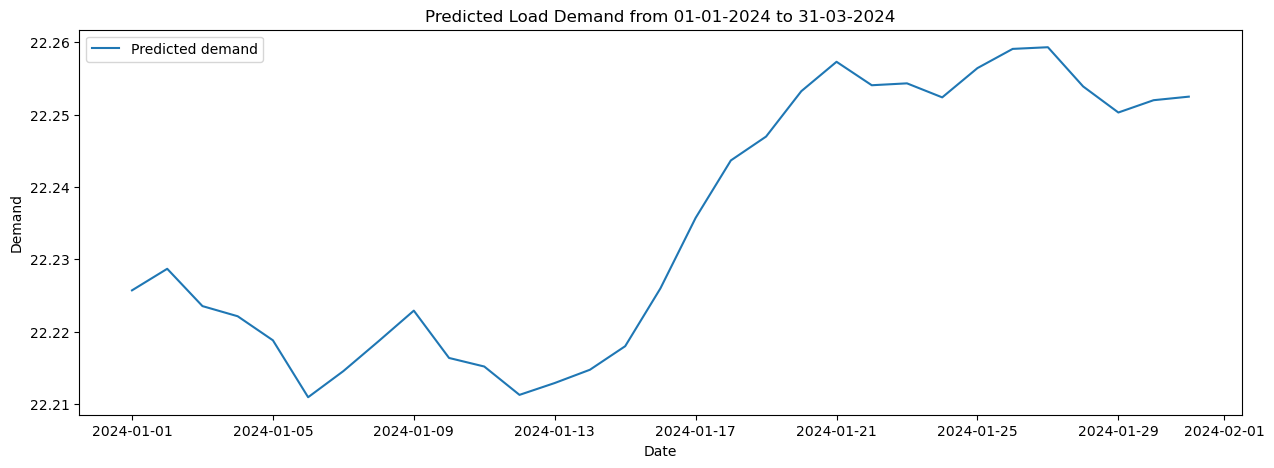

In [77]:
future_data = pd.read_excel('pwdata1.xlsx')
future_data['Date'] = pd.to_datetime(future_data['Date'], format='%d-%m-%Y')
future_data.set_index('Date', inplace=True)

# Prepare the future dataframe
def prepare_future_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    for i in range(1, n_steps+1):
        df[f'DEMAND(t-{i})'] = 0  # Placeholder to match the number of columns
        df[f'Temp(t-{i})'] = df['temp'].shift(i)
        df[f'Humidity(t-{i})'] = df['humidity'].shift(i)
    return df

# Apply the function to the future data
shifted_future_df = prepare_future_dataframe_for_lstm(future_data, lookback)
shifted_future_df=shifted_df_as_np[:, :];
#shifted_future_df_as_np = shifted_future_df.to_numpy()

# Normalize future data
shifted_future_df_as_np = scaler.transform(shifted_future_df)
X_future = shifted_future_df_as_np[:, 3:]  # Ensure the correct number of features (excluding the target)
X_future = dc(np.flip(X_future, axis=1))

# Reshape for LSTM input
X_future = X_future.reshape((-1, lookback, num_features))

# Convert to tensor
X_future = torch.tensor(X_future).float().to(device)

model.eval()
with torch.no_grad():
    future_predictions = model(X_future).cpu().numpy().flatten()

# Inverse transform predictions
dummies = np.zeros((X_future.shape[0], shifted_df_as_np.shape[1]))
dummies[:, 0] = future_predictions
dummies = scaler.inverse_transform(dummies)
future_predictions = dc(dummies[:, 0])

# Create DataFrame for future predictions
future_dates = pd.date_range(start='2024-01-01', periods=len(future_predictions), freq='D')
future_predictions_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['DEMAND'])
future_predictions_df = future_predictions_df[(future_predictions_df.index >= '2024-01-01') & (future_predictions_df.index <= '2024-01-31')]
# Plot future predictions
plt.figure(figsize=(15, 5))
plt.plot(future_predictions_df, label='Predicted demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.title('Predicted Load Demand from 01-01-2024 to 31-03-2024')
plt.legend()
plt.show()